# Sobol Sensitivity Indices for the BTD Model

## Setup packages.

In [1]:
require(data.table)
require(magrittr)
require(rpart)
require(sensitivity)
require(SobolSequence)

require(ggplot2)

Loading required package: data.table
Loading required package: magrittr
Loading required package: rpart
Loading required package: sensitivity
Registered S3 method overwritten by 'sensitivity':
  method    from 
  print.src dplyr
Loading required package: SobolSequence
Loading required package: ggplot2


## Read files.

### Read design.

In [2]:
z.design <- fread("design-si.tsv")
z.design %>% dim

[1] 2500   64

In [3]:
n <- dim(z.design)[1]
k <- dim(z.design)[2] / 2

### Read inputs.

In [4]:
z.inputs <- fread("inputs-si.tsv")
z.inputs %>% dim

[1] 85000    33

In [5]:
z.inputs %>% colnames

[1] "Run"                                     
 [2] "aversion to NPV deviation"               
 [3] "base external investor ask rate"         
 [4] "bioproduct long term price"              
 [5] "bioproduct performance advantage"        
 [6] "commercial capital cost input"           
 [7] "commercial plant capacity"               
 [8] "commercial plant capacity input"         
 [9] "commercial process yield input"          
[10] "commercial variable operating cost input"
[11] "expected continuity of government policy"
[12] "government capital cost share"           
[13] "government production incentive"         
[14] "initial market size"                     
[15] "management response time"                
[16] "market growth rate"                      
[17] "minimum runway"                          
[18] "number of missed stagegates allowed"     
[19] "payback period multiplier"               
[20] "pilot and demo response time"            
[21] "pilot capacity"                          
[22] "piloting acceptable rate"                
[23] "piloting failure default recovery time"  
[24] "piloting failure distribution max"       
[25] "random stream"                           
[26] "required internal return"                
[27] "required return multiplier"              
[28] "researching impact on piloting"          
[29] "startup piloting period"                 
[30] "startup piloting rate"                   
[31] "strategic value to external investors"   
[32] "target demo hours"                       
[33] "target pilot hours"

### Read outputs.

In [7]:
z.outputs <- fread("outputs-si-wide.tsv")

## Take a simpler subset.
* Since the four base cases give very similar results, just use one of them.
* For now, just look at 2050.

In [14]:
yy <- z.outputs[
    Replacement == "Advantaged" & Scale == "Niche" & Time == 2050,
]
yy %>% dim

[1] 85000    53

### Split the input into $x_A$ and $X_B$.

In [11]:
xa <- z.inputs[1:2500]
xa %>% dim

[1] 2500   33

In [12]:
xb <- z.inputs[1:2500 + 2500]
xb %>% dim

[1] 2500   33

### Split the output into the responses to the $y_A$, $y_B$, and $y_{B_{A_i}}$ results.

In [17]:
colnames(y0)[15]

[1] "Cumulative Production"

In [33]:
icol <- 15
y0 <- yy[1:n, icol, with = FALSE][[1]]
ya <- y0[1:n]
ya %>% length

[1] 2500

In [34]:
yb <- y0[1:n + n]
yb %>% length

[1] 2500

In [35]:
ybia <- matrix(y0[-(1:(2*n))], nrow = n, byrow = FALSE)
ybia %>% dim

[1] 2500    0

In [36]:
y0 %>% length

[1] 2500

### Package everything into a data table.

In [13]:
xyab <- NULL
for (i in 1:32) {
    temp <- data.table(
            Input = colnames(z.inputs)[1+i],
            xA = as.matrix(xa[, i + 1, with=FALSE]),
            xB = as.matrix(xb[, i + 1, with=FALSE]),
            yA = ya,
            yB = yb,
            yBiA = ybia[, i]
        )
    colnames(temp) <- c("Input", "xA", "xB", "yA", "yB", "yBiA")
    scale <- sqrt(((temp$yA - temp$yB) %*% (temp$yA - temp$yB))[1])
    xyab <- rbind(
        xyab, cbind(
            Sample = 0,
            temp[, .(Input, xA, xB, yA = yA / scale, yB = yB / scale, yBiA = yBiA / scale)]
        )
    )
    for (j in 1:25) {
        temp2 <- temp[sample(1:nrow(temp), nrow(temp), replace = TRUE)]
        scale <- sqrt(((temp2$yA - temp2$yB) %*% (temp2$yA - temp2$yB))[1])
        xyab <- rbind(
            xyab,
            cbind(
                Sample = j,
                temp2[, .(Input, xA, xB, yA = yA / scale, yB = yB / scale, yBiA = yBiA / scale)]
            )
        )
    }
}
xyab %>% head

Sample,Input,xA,xB,yA,yB,yBiA
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,aversion to NPV deviation,0.060,0.060,2.898561e-05,2.898561e-05,2.898561e-05
0,aversion to NPV deviation,1.360,1.360,0.000000e+00,0.000000e+00,0.000000e+00
0,aversion to NPV deviation,0.710,2.010,0.000000e+00,0.000000e+00,3.446320e-04
0,aversion to NPV deviation,2.010,0.710,0.000000e+00,0.000000e+00,0.000000e+00
0,aversion to NPV deviation,1.685,1.685,0.000000e+00,0.000000e+00,0.000000e+00
0,aversion to NPV deviation,0.385,0.385,0.000000e+00,0.000000e+00,0.000000e+00


## Compute sensitivity indices.

In [14]:
xyab.sensitivity <- xyab[, .(
    S = 1 - sum((yA - yBiA)^2),
    T =     sum((yB - yBiA)^2)
), by = .(Sample, Input)]
xyab.sensitivity[Sample == 0][order(-T)] %>% head

Sample,Input,S,T
<dbl>,<chr>,<dbl>,<dbl>
0,target pilot hours,0.11649125,0.8268736
0,random stream,-0.10268546,0.6641606
0,target demo hours,-0.09407777,0.5960527
0,base external investor ask rate,0.06918549,0.5463625
0,piloting acceptable rate,0.21598993,0.5281508
0,government capital cost share,-0.06742518,0.4382778


### Plot first-order sensitivity index.

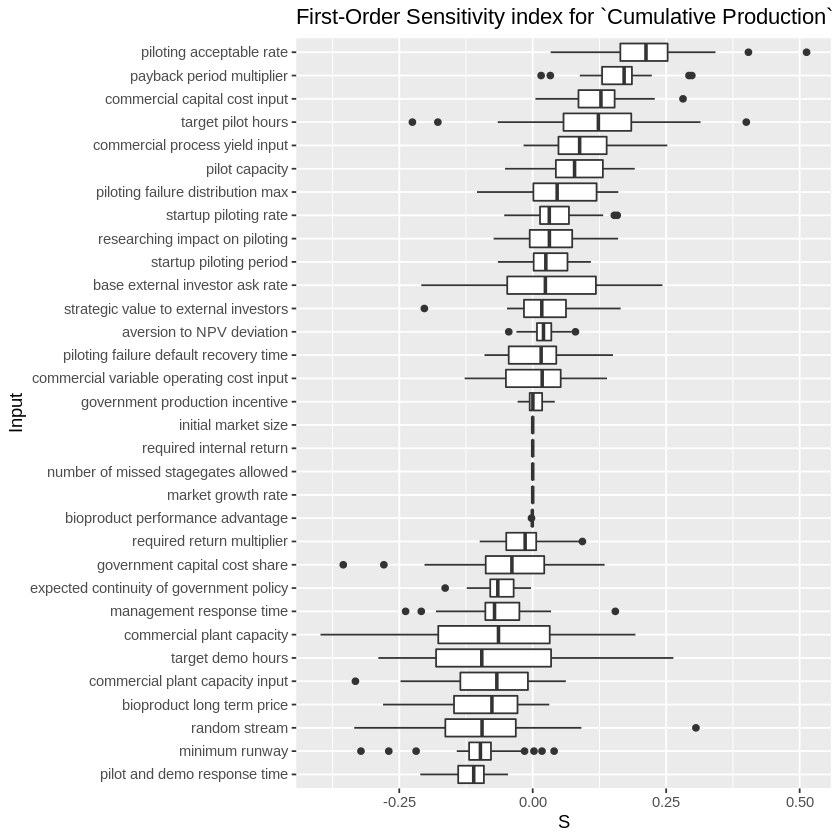

In [15]:
ggplot(xyab.sensitivity, aes(y = S, x = reorder(Input, S, FUN = mean))) +
    geom_boxplot() +
    xlab("Input") +
    coord_flip() +
    ggtitle("First-Order Sensitivity index for `Cumulative Production`")

### Plot total sensitivity index.

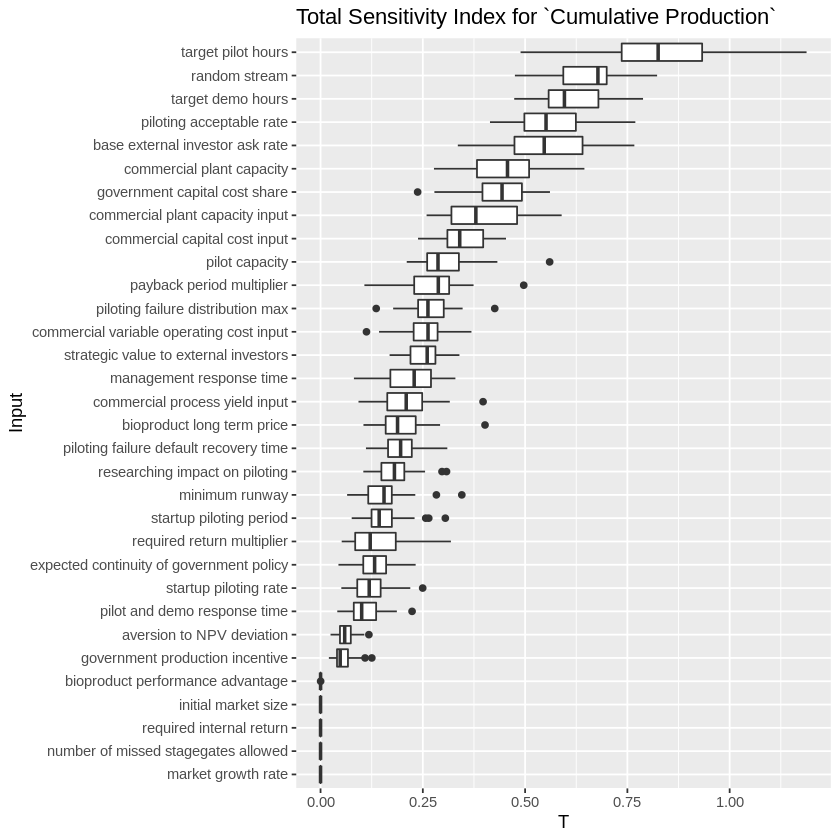

In [16]:
ggplot(xyab.sensitivity, aes(y = T, x = reorder(Input, T, FUN = mean))) +
    geom_boxplot() +
    xlab("Input") +
    coord_flip() +
    ggtitle("Total Sensitivity Index for `Cumulative Production`")

#### Remember most sensitive variables.

In [17]:
xyab.best <- xyab.sensitivity[order(-T)][, unique(Input)][1:6]
xyab.best

[1] "target pilot hours"              "random stream"                  
[3] "target demo hours"               "piloting acceptable rate"       
[5] "base external investor ask rate" "commercial plant capacity"

## Sensitivity variances conditioned by input.

Plot the total sensitivity condition by the input values. Since the results are symmetric in `xA` vs `xB`, plot them both.

### As a function of `xA`.

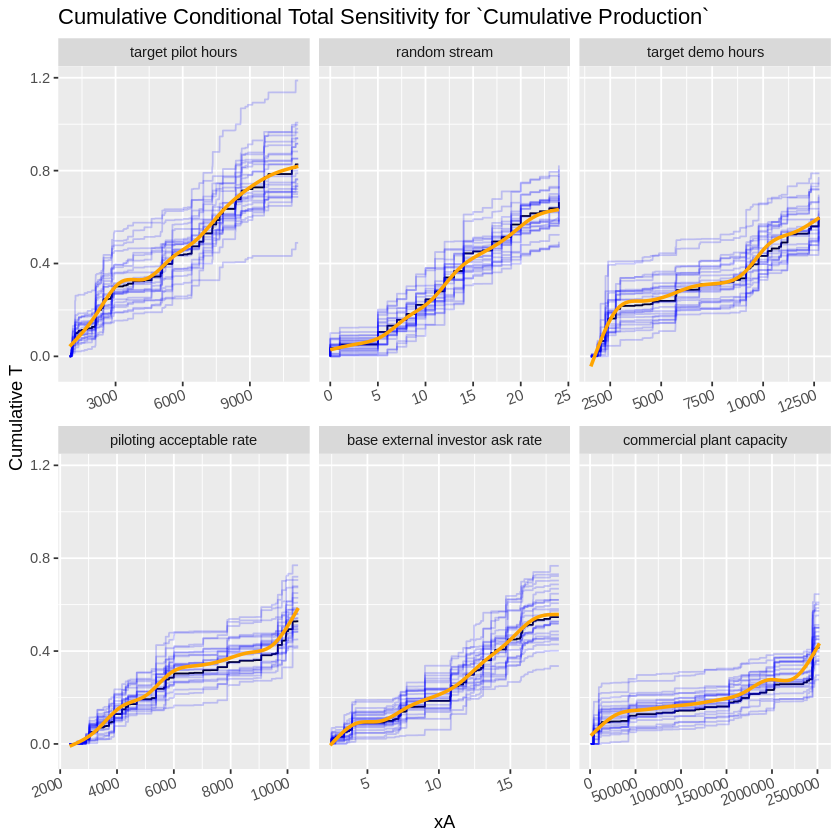

In [18]:
xyab.temp <- xyab[
        Input %in% xyab.best,
        .(Sample, Input=factor(Input, levels = xyab.best), xA, yB, yBiA)
    ][
        order(Input, Sample, xA)
    ][,
      .(xA, T = cumsum((yB - yBiA)^2)), by = .(Input, Sample)
     ]
ggplot(xyab.temp, aes(x = xA, y = T)) +
    geom_line(data = xyab.temp[Sample == 0], color = "black", aes(group = Sample)) +
    geom_line(alpha = 0.2, color = "blue", aes(group = Sample)) +
    geom_smooth(color = "orange", method = "gam", formula = y ~ s(x, bs = "cs")) +
    facet_wrap(Input ~ . , scales = "free_x") +
    theme(axis.text.x = element_text(angle = 20, hjust=1)) +
    ylab("Cumulative T") +
    ggtitle("Cumulative Conditional Total Sensitivity for `Cumulative Production`")

### As a function of `xB`.

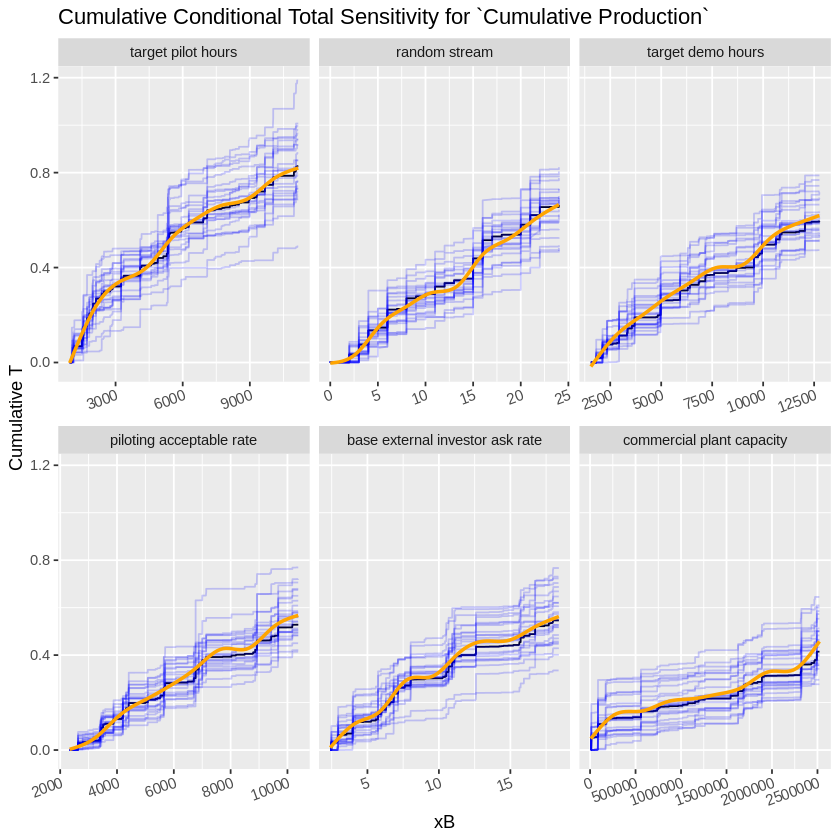

In [19]:
xyab.temp <- xyab[
        Input %in% xyab.best,
        .(Sample, Input=factor(Input, levels = xyab.best), xB, yB, yBiA)
    ][
        order(Input, Sample, xB)
    ][,
      .(xB, T = cumsum((yB - yBiA)^2)), by = .(Input, Sample)
     ]
ggplot(xyab.temp, aes(x = xB, y = T)) +
    geom_line(data = xyab.temp[Sample == 0], color = "black", aes(group = Sample)) +
    geom_line(alpha = 0.2, color = "blue", aes(group = Sample)) +
    geom_smooth(color = "orange", method = "gam", formula = y ~ s(x, bs = "cs")) +
    facet_wrap(Input ~ . , scales = "free_x") +
    theme(axis.text.x = element_text(angle = 20, hjust=1)) +
    ylab("Cumulative T") +
    ggtitle("Cumulative Conditional Total Sensitivity for `Cumulative Production`")

### With `xA` and `xB` interleaved.

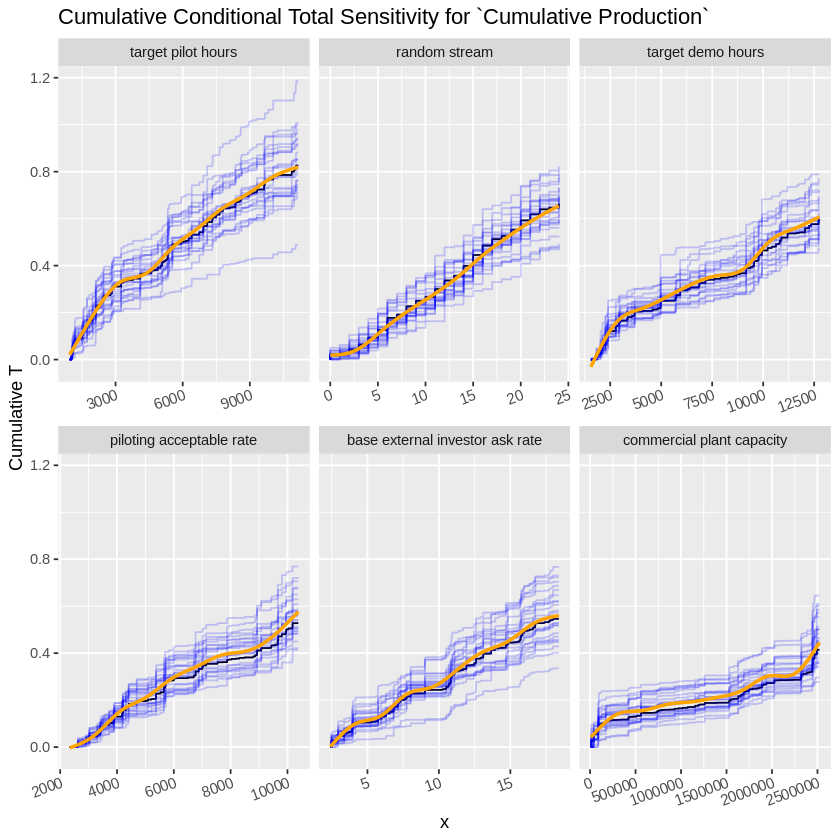

In [20]:
xyab.temp <- rbind(xyab[, .(Input, Sample, x = xA, yB, yBiA)], xyab[, .(Input, Sample, x = xB, yB, yBiA)])[
        Input %in% xyab.best,
        .(Sample, Input=factor(Input, levels = xyab.best), x, yB = yB / sqrt(2), yBiA = yBiA / sqrt(2))
    ][
        order(Input, Sample, x)
    ][,
      .(x, T = cumsum((yB - yBiA)^2)), by = .(Input, Sample)
     ]
ggplot(xyab.temp, aes(x = x, y = T)) +
    geom_line(data = xyab.temp[Sample == 0], color = "black", aes(group = Sample)) +
    geom_line(alpha = 0.2, color = "blue", aes(group = Sample)) +
    geom_smooth(color = "orange", method = "gam", formula = y ~ s(x, bs = "cs")) +
    facet_wrap(Input ~ . , scales = "free_x") +
    theme(axis.text.x = element_text(angle = 20, hjust=1)) +
    ylab("Cumulative T") +
    ggtitle("Cumulative Conditional Total Sensitivity for `Cumulative Production`")

## Candidate locations for splitting into regimes with different sensitvities.

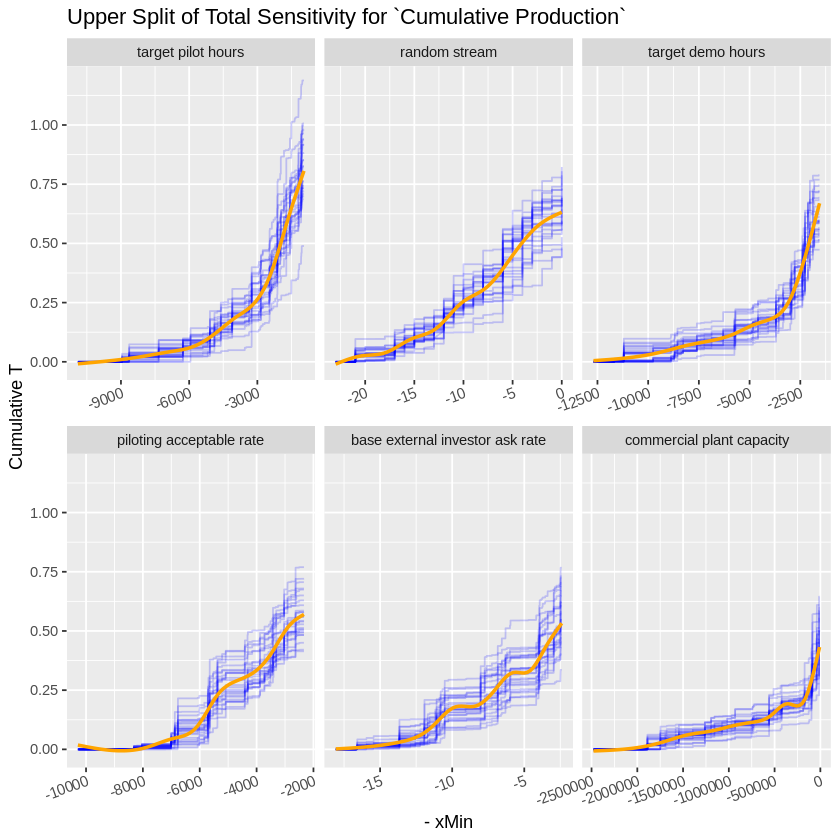

In [21]:
ggplot(
    xyab[
        Input %in% xyab.best,
        .(Sample, Input=factor(Input, levels = xyab.best), xMin=-mapply(min, xA, xB), yB, yBiA)
    ][
        order(Input, Sample, xMin)
    ][,
      .(xMin, T = cumsum((yB - yBiA)^2)), by = .(Input, Sample)
    ][,
     ],
        aes(x = xMin, y = T)
    ) +
    geom_line(alpha = 0.2, color = "blue", aes(group = Sample)) +
    geom_smooth(color = "orange", method = "gam", formula = y ~ s(x, bs = "cs")) +
    facet_wrap(Input ~ . , scales = "free_x") +
    theme(axis.text.x = element_text(angle = 20, hjust=1)) +
#   scale_x_reverse() +
    xlab("- xMin") +
    ylab("Cumulative T") +
    ggtitle("Upper Split of Total Sensitivity for `Cumulative Production`")

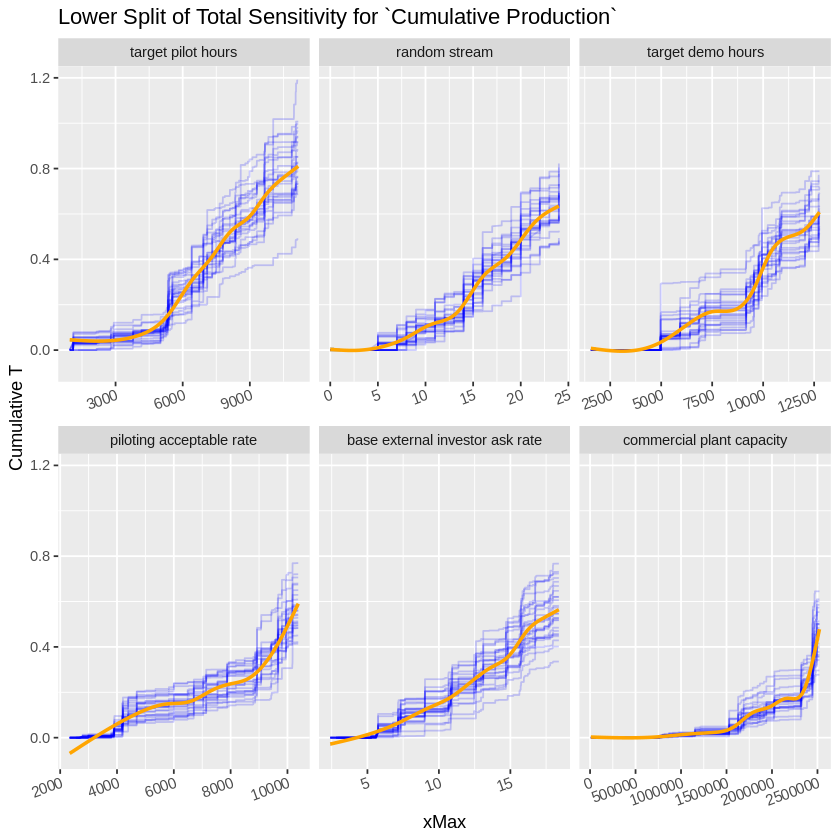

In [22]:
ggplot(
    xyab[
        Input %in% xyab.best,
        .(Sample, Input=factor(Input, levels = xyab.best), xMax=mapply(max, xA, xB), yB, yBiA)
    ][
        order(Input, Sample, xMax)
    ][,
      .(xMax, T = cumsum((yB - yBiA)^2)), by = .(Input, Sample)
     ],
        aes(x = xMax, y = T)
    ) +
    geom_line(alpha = 0.2, color = "blue", aes(group = Sample)) +
    geom_smooth(color = "orange", method = "gam", formula = y ~ s(x, bs = "cs")) +
    facet_wrap(Input ~ . , scales = "free_x") +
    theme(axis.text.x = element_text(angle = 20, hjust=1)) +
    ylab("Cumulative T") +
    ggtitle("Lower Split of Total Sensitivity for `Cumulative Production`")